#Name : Saarthak Khamkar  
#Roll No. : D088
#SAP ID : 60009230057

In [6]:
# Imports and helpers
import numpy as np
import matplotlib.pyplot as plt
from math import erf

# small epsilon for numeric stability
EPS = 1e-12

# Activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

def gelu(x):
    # exact GELU: x * Phi(x) where Phi is Gaussian CDF
    # Use erf from math (vectorized via numpy.vectorize) for numerical stability
    erf_v = np.vectorize(erf)
    Phi = 0.5 * (1 + erf_v(x / np.sqrt(2)))
    return x * Phi

def elu(x, alpha=1.0):
    out = np.where(x > 0, x, alpha * (np.exp(x) - 1))
    return out

def swish(x):
    return x * sigmoid(x)

def softmax(logits, axis=-1):
    z = logits - np.max(logits, axis=axis, keepdims=True)
    exp_z = np.exp(z)
    return exp_z / (np.sum(exp_z, axis=axis, keepdims=True) + EPS)

# Analytical derivatives (where straightforward)
def dsigmoid(x):
    s = sigmoid(x)
    return s * (1 - s)

def dtanh(x):
    return 1 - np.tanh(x) ** 2

def drelu(x):
    return np.where(x > 0, 1.0, 0.0)

def dgelu(x):
    # derivative of GELU(x) = Phi(x) + x * phi(x) where phi is Gaussian pdf
    phi = np.exp(-0.5 * x ** 2) / np.sqrt(2 * np.pi)
    erf_v = np.vectorize(erf)
    Phi = 0.5 * (1 + erf_v(x / np.sqrt(2)))
    return Phi + x * phi

def delu(x, alpha=1.0):
    return np.where(x > 0, 1.0, alpha * np.exp(x))

def dswish(x):
    s = sigmoid(x)
    return s + x * s * (1 - s)

# For softmax we usually work with Jacobian. For plotting we will compute numerical gradient across a varying scalar input.

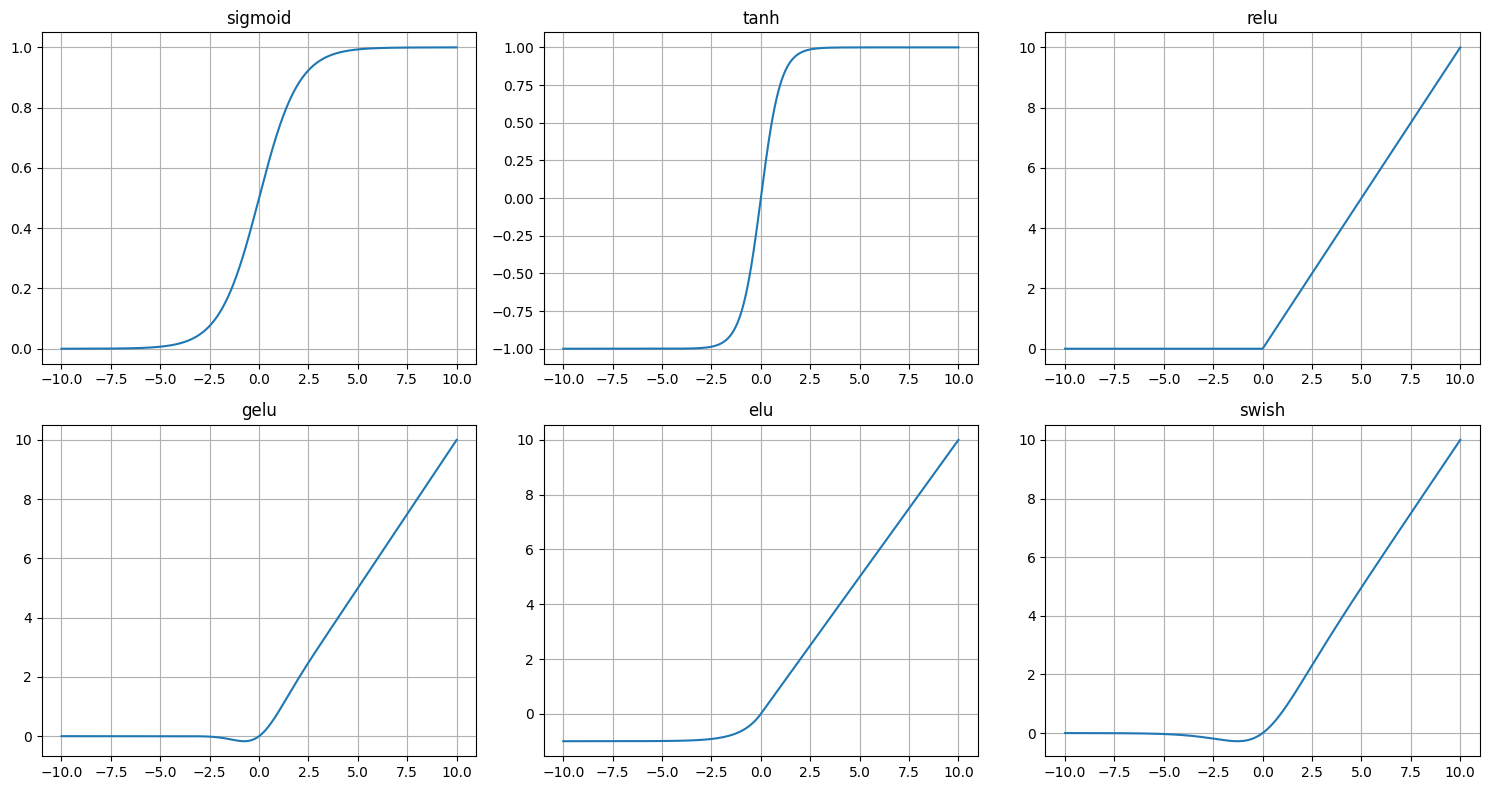

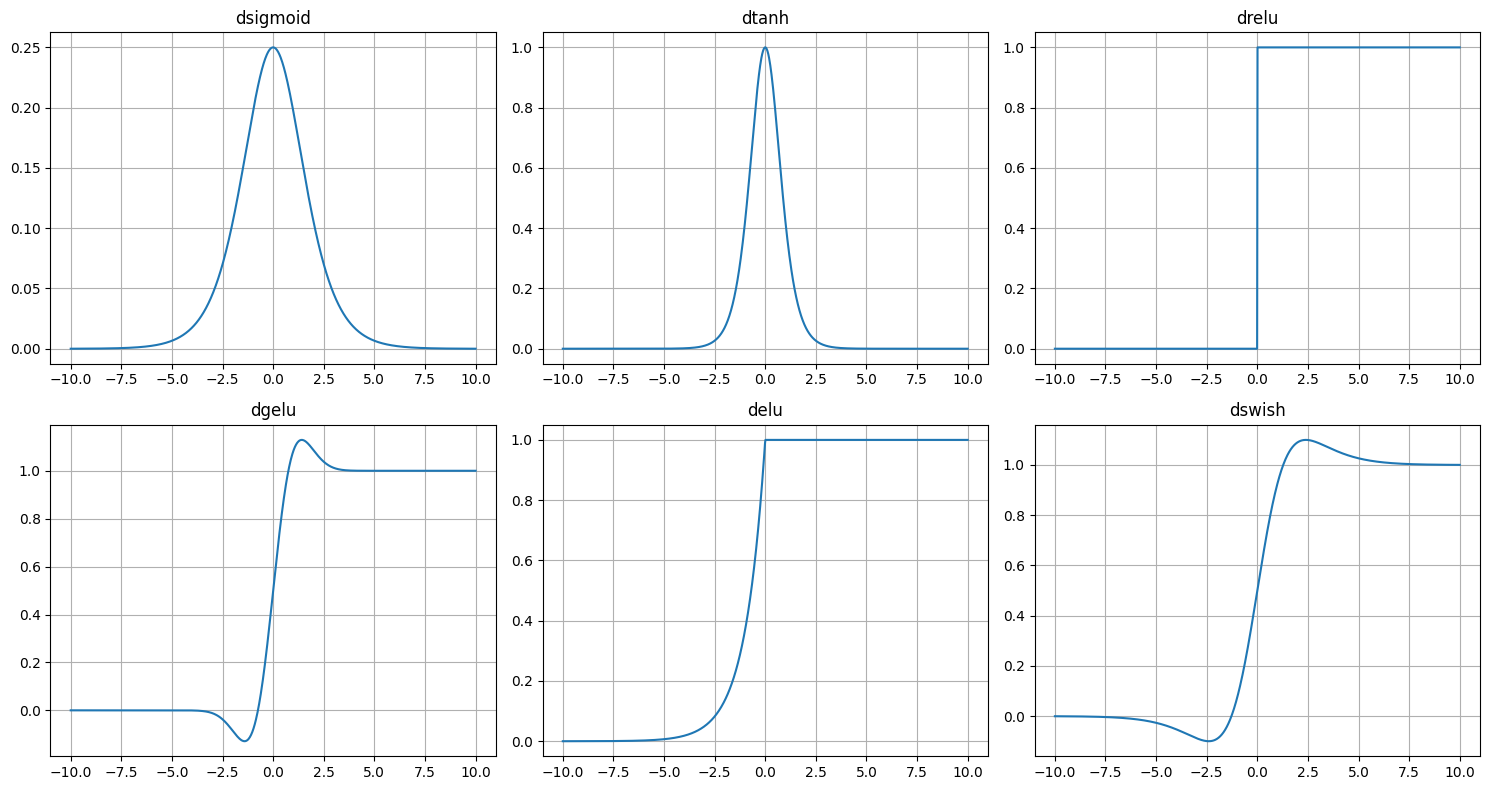

In [7]:
# Plot activations and derivatives over x in (-10, 10)
x = np.linspace(-10, 10, 1000)
acts = {
    'sigmoid': sigmoid(x),
    'tanh': tanh(x),
    'relu': relu(x),
    'gelu': gelu(x),
    'elu': elu(x),
    'swish': swish(x)
}
ders = {
    'sigmoid': dsigmoid(x),
    'tanh': dtanh(x),
    'relu': drelu(x),
    'gelu': dgelu(x),
    'elu': delu(x),
    'swish': dswish(x)
}

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, (name, yvals) in enumerate(acts.items()):
    axes[i].plot(x, yvals, label=name)
    axes[i].set_title(name)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()
for i, (name, yvals) in enumerate(ders.items()):
    axes[i].plot(x, yvals, label='d' + name)
    axes[i].set_title('d' + name)
    axes[i].grid(True)
plt.tight_layout()
plt.show()

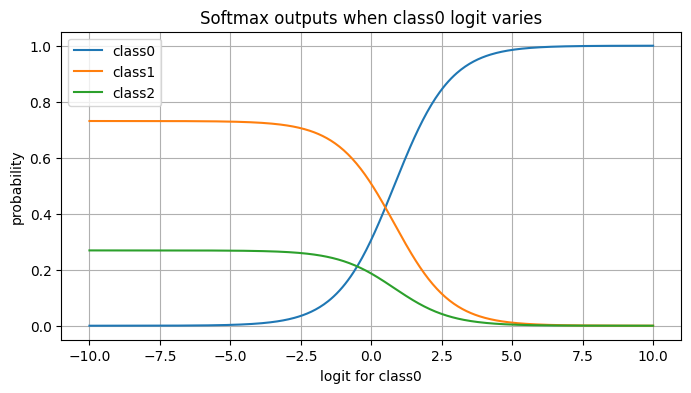

In [8]:
# Softmax plotting example: vary a single logit while keeping others fixed (3-class example)
xs = np.linspace(-10, 10, 400)
probs = np.zeros((3, xs.size))
for i, xv in enumerate(xs):
    logits = np.array([xv, 0.5, -0.5])
    p = softmax(logits)
    probs[:, i] = p

plt.figure(figsize=(8, 4))
plt.plot(xs, probs[0], label='class0')
plt.plot(xs, probs[1], label='class1')
plt.plot(xs, probs[2], label='class2')
plt.title('Softmax outputs when class0 logit varies')
plt.xlabel('logit for class0')
plt.ylabel('probability')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
# Loss / Error functions implementations
def mse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true, y_pred):
    return np.mean(np.abs(np.asarray(y_true) - np.asarray(y_pred)))

def huber(y_true, y_pred, delta=1.0):
    err = np.asarray(y_pred) - np.asarray(y_true)
    abs_err = np.abs(err)
    is_small = abs_err <= delta
    squared_loss = 0.5 * err ** 2
    linear_loss = delta * (abs_err - 0.5 * delta)
    return np.mean(np.where(is_small, squared_loss, linear_loss))

def binary_cross_entropy(y_true, p):
    p = np.clip(p, EPS, 1 - EPS)
    y_true = np.asarray(y_true)
    return -np.mean(y_true * np.log(p) + (1 - y_true) * np.log(1 - p))

def categorical_cross_entropy(y_true_onehot, p):
    p = np.clip(p, EPS, 1 - EPS)
    y = np.asarray(y_true_onehot)
    return -np.sum(y * np.log(p)) / y.shape[0] if y.ndim > 1 else -np.sum(y * np.log(p))

def kl_divergence(q, p):
    q = np.asarray(q)
    p = np.asarray(p)
    q = np.clip(q, EPS, 1)
    p = np.clip(p, EPS, 1)
    return np.sum(q * np.log(q / p))

def cosine_similarity_loss(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    num = np.sum(a * b)
    denom = (np.linalg.norm(a) * np.linalg.norm(b)) + EPS
    cos_sim = num / denom
    return 1 - cos_sim

In [10]:
# Example evaluations for loss functions
# Regression example
y_true = np.array([1.5, 0.0, -2.0])
y_pred = np.array([1.4, 0.6, -1.8])
print('MSE:', mse(y_true, y_pred))
print('MAE:', mae(y_true, y_pred))
print('Huber (delta=1):', huber(y_true, y_pred, delta=1.0))

# Binary classification example
y_bin = np.array([1, 0, 1, 0])
p_bin = np.array([0.9, 0.2, 0.6, 0.1])
print('Binary CE:', binary_cross_entropy(y_bin, p_bin))

# Categorical example (single sample)
logits = np.array([2.0, 1.0, 0.1])
p_cat = softmax(logits)
y_onehot = np.array([1, 0, 0])
print('Categorical CE:', categorical_cross_entropy(y_onehot, p_cat))

# KL divergence and Cosine similarity loss
q = np.array([0.7, 0.2, 0.1])
p = np.array([0.6, 0.3, 0.1])
print('KL(q||p):', kl_divergence(q, p))
a = np.array([1.0, 2.0, 3.0])
b = np.array([1.0, 0.5, -1.0])
print('CosineSimLoss(a,b):', cosine_similarity_loss(a, b))

# Notes (markdown)

# Notes
# - Softmax is shown for a 3-class case by varying one logit while keeping others constant.
# - Some derivatives (e.g., softmax Jacobian) are more naturally represented as matrices — here derivatives for scalar-varying softmax are visualized numerically.
# - The notebook provides example usages for the requested loss functions.

MSE: 0.13666666666666666
MAE: 0.3
Huber (delta=1): 0.06833333333333333
Binary CE: 0.23617255159896328
Categorical CE: 0.41703001627849257
KL(q||p): 0.026812454257447993
CosineSimLoss(a,b): 1.178174161274918


Colab Link: https://colab.research.google.com/drive/1-2rguJmEqiQiFnlhdv14NnN_E6txjLYR?usp=sharing